In [2]:
import pandas as pd
import numpy as np
import os
import json
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import root_mean_squared_error, r2_score, make_scorer
import matplotlib.pyplot as plt

C:\Users\Mickey\anaconda3\Lib\site-packages\sklearn\utils\__init__.py:16: UserWarning: A NumPy version >=1.23.5 and <2.5.0 is required for this version of SciPy (detected version 1.23.2)
  from scipy.sparse import issparse


In [3]:
NYC_df = pd.read_csv('data/NYC_trunc.csv',low_memory=False)
CHI_df = pd.read_csv('data/CHI_trunc.csv',low_memory=False)

In [4]:
cols_to_keep = [
    'date', 
    'mode', 
    'daily_ridership',
    'us_aqi_mean',
    'us_aqi_pm2_5_mean',
    'us_aqi_pm10_mean',
    'us_aqi_nitrogen_dioxide_mean',
    'us_aqi_ozone_mean',
    'us_aqi_sulphur_dioxide_mean',
    'us_aqi_carbon_monoxide_mean',
    'apparent_temperature_max',
    'apparent_temperature_min',
    'apparent_temperature_max_lag',
    'apparent_temperature_min_lag',
    'relative_humidity_2m_mean',
    'rain_sum',
    'rain_max',
    'snow_any',
    'snow_heavy',
    'wind_speed_10m_mean',
    'wind_speed_10m_max',
    'wind_direction_10m_mean',
    'is_holiday_adjacent',
    'is_weekend',
    'is_holiday'
]



NYC_df = NYC_df[cols_to_keep]
CHI_df = CHI_df[cols_to_keep]

In [5]:
def randforr(df, cv_folds=5):
    for mode_val in df['mode'].dropna().unique():
              
        df_mode = df[df['mode'] == mode_val].copy()
        drop_cols = ['state', 'unit_id', 'mode']
        df_mode = df_mode.drop(columns=[col for col in drop_cols if col in df_mode.columns], errors='ignore')

        y = df_mode['daily_ridership']
        X = df_mode.drop(columns=['daily_ridership', 'date'])

        test_size = int(len(X) * 0.2)
        X_train, X_test = X.iloc[:-test_size], X.iloc[-test_size:]
        y_train, y_test = y.iloc[:-test_size], y.iloc[-test_size:]

        # Grid search for best parameter
        rf = RandomForestRegressor(random_state=27, n_jobs=-1)
        param_grid = {
            'n_estimators': [50, 100, 150, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5, 10, 25],
            'min_samples_leaf': [1, 2, 5, 10]
        }
        grid_search = GridSearchCV(rf, param_grid, cv=cv_folds, scoring='r2', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        rf = grid_search.best_estimator_
        print("Best Parameters:", grid_search.best_params_)

        # Cross-val scoring
        tscv = TimeSeriesSplit(n_splits=cv_folds)
        r2_scores = []
        rmse_scores = []

        for inner_train_idx, inner_val_idx in tscv.split(X_train, y_train):
            X_inner_train, X_inner_val = X_train.iloc[inner_train_idx], X_train.iloc[inner_val_idx]
            y_inner_train, y_inner_val = y_train.iloc[inner_train_idx], y_train.iloc[inner_val_idx]

            rf.fit(X_inner_train, y_inner_train)
            y_val_pred = rf.predict(X_inner_val)

            r2_scores.append(r2_score(y_inner_val, y_val_pred))
            rmse_scores.append(root_mean_squared_error(y_inner_val, y_val_pred))


        print("R² scores (CV):", r2_scores)
        print("RMSE scores (CV):", rmse_scores)
        print(f"Mean R²: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")
        print(f"Mean RMSE: {np.mean(rmse_scores):.2f} ± {np.std(rmse_scores):.2f}")

        importances = rf.feature_importances_
        feat_names = X_train.columns
        sorted_idx = np.argsort(importances)[::-1]
        plt.barh(range(10), importances[sorted_idx[:10]])
        plt.yticks(range(10), feat_names[sorted_idx[:10]])
        plt.xlabel("Feature Importance")
        plt.title(f"Top 10 Important Features ({mode_val})")
        plt.gca().invert_yaxis()
        plt.show()

        rf.fit(X_train, y_train)
        y_pred_test = rf.predict(X_test)
        print(f"Test R²: {r2_score(y_test, y_pred_test):.4f}")
        print(f"Test RMSE: {root_mean_squared_error(y_test, y_pred_test):.2f}")

Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
R² scores (CV): [0.30105928513302205, -0.238872236216779, 0.3380308155336579, -0.23874378262684126, -0.8842453352333977]
RMSE scores (CV): [407.2607130249409, 572.6074236059723, 610.0622111673033, 604.8905169445882, 534.0568472773824]
Mean R²: -0.1446 ± 0.4464
Mean RMSE: 545.78 ± 74.39


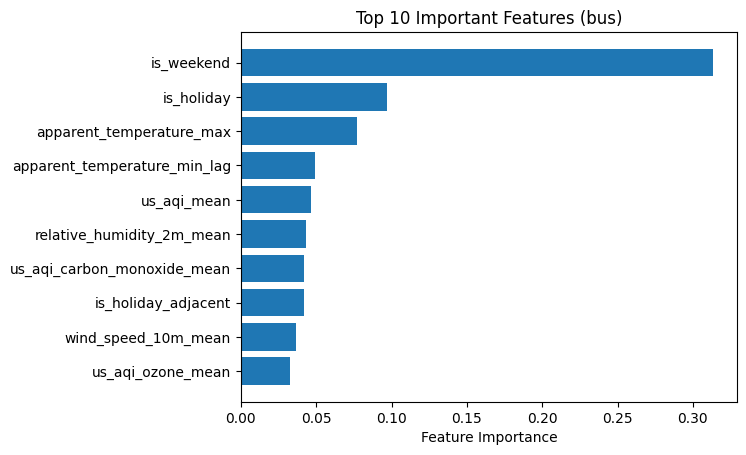

Test R²: 0.2513
Test RMSE: 634.96
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
R² scores (CV): [0.4707034333226495, 0.22152662192538197, 0.586425983640279, 0.6406941266596907, 0.5620322671470517]
RMSE scores (CV): [310.2285329987084, 358.8699201541029, 356.0625138400196, 286.61199242960095, 276.65104078316716]
Mean R²: 0.4963 ± 0.1480
Mean RMSE: 317.68 ± 34.28


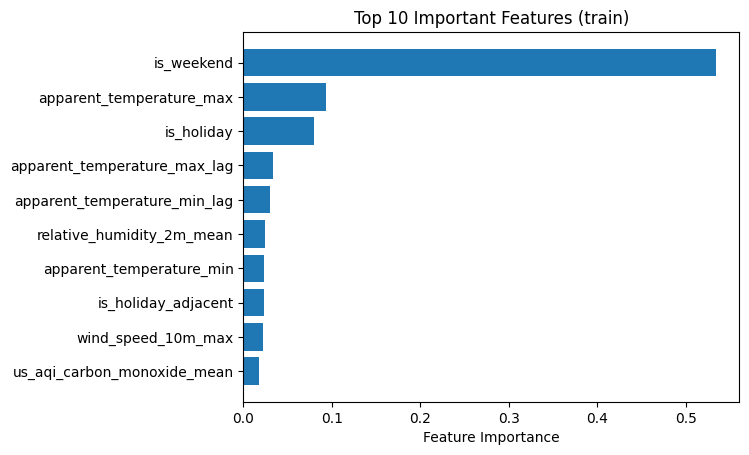

Test R²: 0.5832
Test RMSE: 337.46


In [6]:
randforr(CHI_df)

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 25, 'n_estimators': 50}
R² scores (CV): [0.8927857927952702, 0.8748808744499593, 0.6059518758201989, 0.771008110218931, 0.786396078969822]
RMSE scores (CV): [248.46810046280652, 244.92705195163703, 464.43466172666075, 316.9971411478718, 288.5636347876195]
Mean R²: 0.7862 ± 0.1019
Mean RMSE: 312.68 ± 80.43


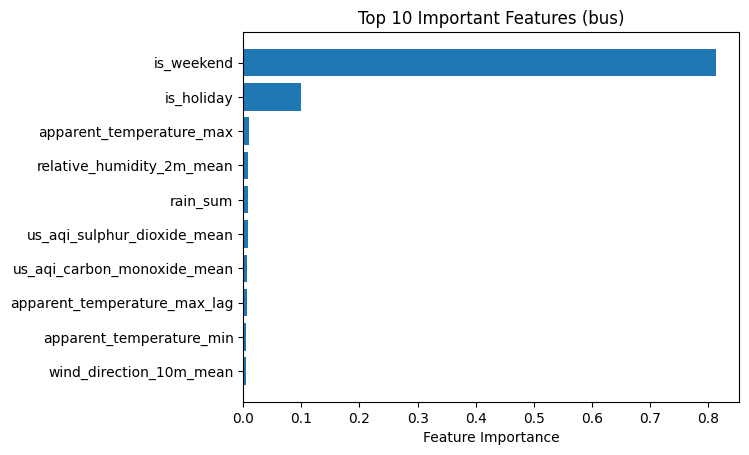

Test R²: 0.7779
Test RMSE: 356.33
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 25, 'n_estimators': 200}
R² scores (CV): [0.7539589763284749, 0.7956189402272771, 0.771937723573086, 0.840980531757655, 0.8350108771528885]
RMSE scores (CV): [890.3022882844989, 787.2642044638893, 943.892946424043, 735.4589531357793, 725.5435284504316]
Mean R²: 0.7995 ± 0.0341
Mean RMSE: 816.49 ± 86.45


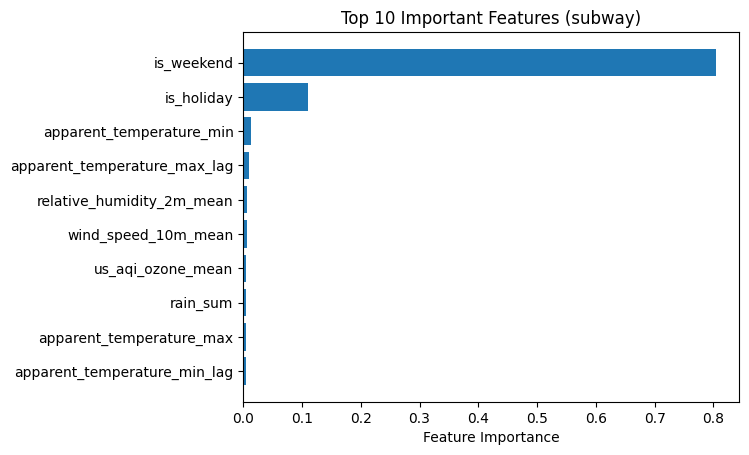

Test R²: 0.6751
Test RMSE: 1125.02


In [7]:
randforr(NYC_df)

In [8]:
def randforrcomb(df, cv_folds=5):
    drop_cols = ['state', 'unit_id', 'mode']
    df = df.drop(columns=[col for col in drop_cols if col in df.columns], errors='ignore')
    
    y = df['daily_ridership']
    X = df.drop(columns=['daily_ridership', 'date'])
    test_size = int(len(X) * 0.2)
    X_train, X_test = X.iloc[:-test_size], X.iloc[-test_size:]
    y_train, y_test = y.iloc[:-test_size], y.iloc[-test_size:]

    # Grid search for best parameters
    rf = RandomForestRegressor(random_state=27, n_jobs=-1)
    param_grid = {
        'n_estimators': [50, 100, 150, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10, 25],
        'min_samples_leaf': [1, 2, 5, 10]
    }
    grid_search = GridSearchCV(rf, param_grid, cv=cv_folds, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    rf = grid_search.best_estimator_
    print("Best Parameters:", grid_search.best_params_)

    # Cross-val scoring
    tscv = TimeSeriesSplit(n_splits=cv_folds)
    r2_scores = []
    rmse_scores = []

    for inner_train_idx, inner_val_idx in tscv.split(X_train, y_train):
        X_inner_train, X_inner_val = X_train.iloc[inner_train_idx], X_train.iloc[inner_val_idx]
        y_inner_train, y_inner_val = y_train.iloc[inner_train_idx], y_train.iloc[inner_val_idx]

        rf.fit(X_inner_train, y_inner_train)
        y_val_pred = rf.predict(X_inner_val)

        r2_scores.append(r2_score(y_inner_val, y_val_pred))
        rmse_scores.append(root_mean_squared_error(y_inner_val, y_val_pred))

    print("R² scores (CV):", r2_scores)
    print("RMSE scores (CV):", rmse_scores)
    print(f"Mean R²: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")
    print(f"Mean RMSE: {np.mean(rmse_scores):.2f} ± {np.std(rmse_scores):.2f}")

    importances = rf.feature_importances_
    feat_names = X_train.columns
    sorted_idx = np.argsort(importances)[::-1]
    plt.barh(range(10), importances[sorted_idx[:10]])
    plt.yticks(range(10), feat_names[sorted_idx[:10]])
    plt.xlabel("Feature Importance")
    plt.title("Top 10 Important Features")
    plt.gca().invert_yaxis()
    plt.show()


    # Eval Test Set
    rf.fit(X_train, y_train)
    y_test_pred = rf.predict(X_test)
    print(f"\nFinal Test R²: {r2_score(y_test, y_test_pred):.4f}")
    print(f"Final Test RMSE: {root_mean_squared_error(y_test, y_test_pred):.2f}")


In [9]:
CHI_df = CHI_df.drop(columns='mode', errors='ignore')
NYC_df = NYC_df.drop(columns='mode', errors='ignore')

concat_df = pd.concat([CHI_df, NYC_df], ignore_index=True)

comb_df = concat_df.groupby('date', as_index=False).agg('first')  
comb_df['daily_ridership'] = concat_df.groupby('date')['daily_ridership'].sum().values

Best Parameters: {'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 25, 'n_estimators': 100}
R² scores (CV): [0.7059629966355525, 0.7250913078994621, 0.7178431335314794, 0.8411654774251619, 0.7887653256520845]
RMSE scores (CV): [1822.232285873383, 1687.731012986689, 2073.049167682688, 1354.388045566351, 1417.823040696165]
Mean R²: 0.7558 ± 0.0515
Mean RMSE: 1671.04 ± 264.25


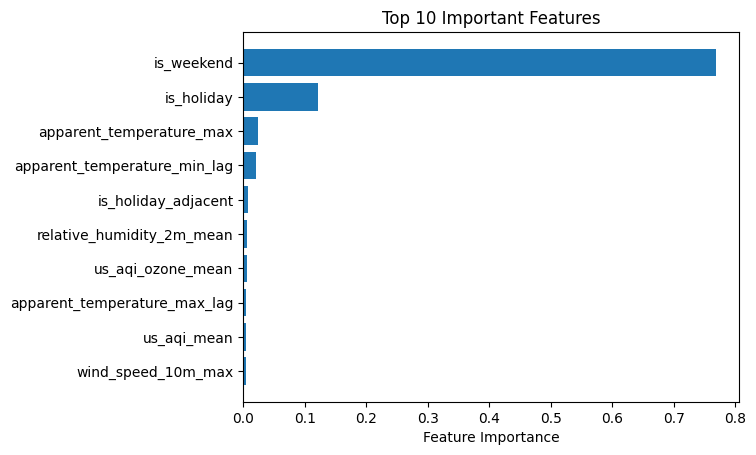


Final Test R²: 0.6264
Final Test RMSE: 2326.71


In [10]:
randforrcomb(comb_df)